In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

In [9]:
import pandas as pd
import numpy as np

# This function now creates and RETURNS the DataFrame
def regenerate():
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    # The original code has a bug here, y depends on x, but x has NaNs.
    # For a robust solution, we generate y before introducing NaNs into x.
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    # The to_csv part is optional here, but we'll leave it
    # csv_path = 'data/data_stage11_eval_risk.csv'
    # df.to_csv(csv_path, index=False)
    return df

# Now, call the function and store its output in the 'df' variable
df = regenerate()

# This will now work correctly
df.head()

,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


In [11]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)

def pred_fn(model, X):
    return model.predict(X)

print("Helper functions defined.\\n" + "="*60 + "\\n")

Helper functions defined.\n============================================================\n


In [15]:
X_raw = df['x_feature'].values
y = df['y_target'].values

X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base

base_mae = mae(y, y_hat)
print(f"Baseline MAE: {base_mae:.4f}")
print("\\n" + "="*60 + "\\n")


Baseline MAE: 1.2783
\n============================================================\n


In [17]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)

# Parametric (Gaussian) CI calculation
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

# Bootstrap CI calculation
def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

Scenario Sensitivity Results:
        scenario       mae     slope  intercept
0    mean_impute  1.278317  2.130236   0.711523
1  median_impute  1.283954  2.129290   0.727146
2   drop_missing  1.064603  2.130236   0.659164


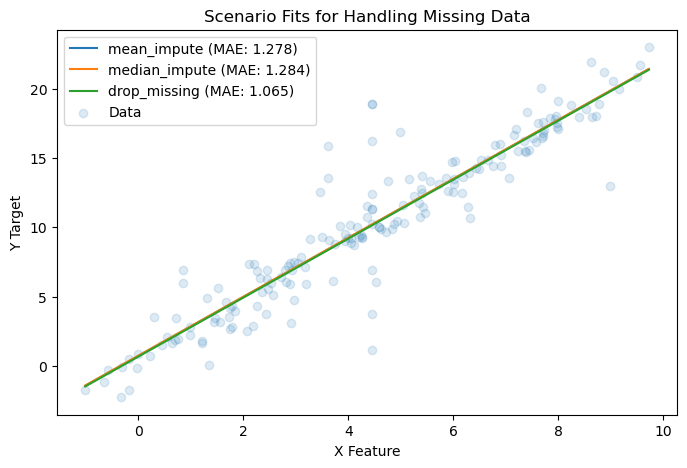

Plotted Scenario Sensitivity.\n============================================================\n


In [19]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)]
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing':
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
        current_mae = mae(ys, yh)
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
        current_mae = mae(y, yh)
    results.append({'scenario': name, 'mae': current_mae, 'slope': m.coef_[0], 'intercept': m.intercept_})

sens = pd.DataFrame(results)
print("Scenario Sensitivity Results:")
print(sens)

# Plotting the scenarios
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing':
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=f"{name} (MAE: {sens[sens.scenario==name]['mae'].iloc[0]:.3f})")

plt.scatter(X_base, y, alpha=0.15, label='Data')
plt.title('Scenario Fits for Handling Missing Data')
plt.xlabel('X Feature')
plt.ylabel('Y Target')
plt.legend()
plt.show()
print("Plotted Scenario Sensitivity.\\n" + "="*60 + "\\n")

Residuals by Subgroup:
             mean       std    median  count
segment                                     
A       -0.066306  1.827501 -0.235648     94
B        0.294967  1.707514 -0.077390     41
C       -0.130242  2.813215 -0.140354     45


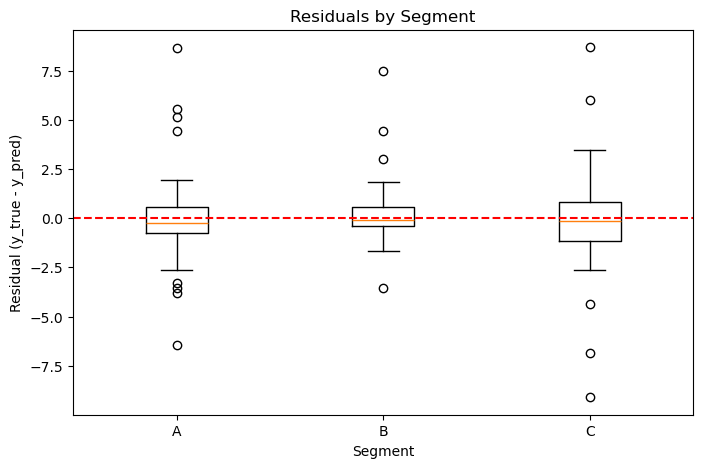

Plotted Subgroup Diagnostics.\n============================================================\n


In [21]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
print("Residuals by Subgroup:")
print(g)

# Plotting the residuals by subgroup
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals by Segment')
plt.xlabel('Segment')
plt.ylabel('Residual (y_true - y_pred)')
plt.show()
print("Plotted Subgroup Diagnostics.\\n" + "="*60 + "\\n")

In [23]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
print("Bootstrapped MAE (95% CI):")
print(bm)
print("\\n" + "="*60 + "\\n")
print("Analysis complete.")

Bootstrapped MAE (95% CI):
{'mean': 1.2714062440720533, 'lo': 1.0550822262814081, 'hi': 1.530997972363559}
\n============================================================\n
Analysis complete.
